In [2]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer

from trata import sampler as sm, composite_samples as cs, adaptive_sampler as ad
from ibis import mcmc as mc, plots
import themis
import os
# %matplotlib notebook
  
# use this instead of %matplotlib notebook if using vscode, unless you install the matplotlib extension
%matplotlib widget   

Uncertainty Estimation via MCMC
===============================
In our bouncing ball example, we want to estimate the distribution of how many times the ball bounces off the ground until rest given a starting position, velocity, and gravity. 

An MCMC algorithm allows to simulate a probability distribution by constructing a Markov chain with the desired distribution as its stationary distribution. The MCMC algorithm iteratively updates the Markov chain based on the transition probability from one state to another state. Eventually, the chain attains the state of equilibrium when the joint probability distribution for the current state approaches the stationary distribution. The parameters that lead to the stationary distribution are considered as the model parameters learnt for the particular training image. 

Each state of a Markov chain is obtained by sampling a probability distribution. Among various sampling techniques, Metropolis algorithm and Gibbs sampler are two most well-known ones. See the appendix at the bottom for details. 


## Sampling for Uncertainty Quantification

The Gaussian process model requires specification of two kinds of inputs:

1. $x$ = $(x_1,x_2,...,x_p)$ denotes inputs that are under the control of (or are observable by) the experimenter in both the field experiments and the simulator runs. In our bouncing ball example, there are $p=3$ inputs of this type:
    - $x_1=R=1$, the radius of the ball
    - $x_2=D=1$, the density of the ball
    - $x_3=C=0.1$, the coefficient of drag
    
<br>

2. $\theta$ = $(\theta_1,\theta_2,...,\theta_q)$ denotes inputs to the simulator that are needed to estimate using the experimental data. These $\theta$ could correspond to real physical quantities or could be parameters of the simulator code. In our bouncing ball example, there are $q=3$ inputs of this type: 
    - $\theta_1=P=[0,100]$, the initial position of ball
    - $\theta_2=V=[-10,10]$, the initial velocity of the ball
    - $\theta_3=G=[1,10]$, the force of gravity acting on the ball


$\theta$ parameters of the bouncing ball model need to be appropriately sampled in order to build an accurate surrogate that honors the ground truth.

### Generate Data
To get started we need to generate data by launching our bouncing ball studies by running the command:

`maestro run ball_bounce_suite.yaml --pgen pgen.py`


In [3]:
# Initialization

database = 'output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")


Sina is ready!


In [4]:

groups = set(x["group_id"]["value"] for x in recs.get_data(["group_id"]).values())

print("So far we've run {} experiment groups each with 10 studies.".format(len(groups)))
print("We queried our database and found the following groups: {}".format(groups))


So far we've run 4 experiment groups each with 10 studies.
We queried our database and found the following groups: {'f5be0b', 'fc8557', '9bb55f', 'c6abce'}


We want to check the range of our target variable, the `num_bounces`, across our data groups.

Dropdown(description='x data name:', index=3, options=('box_side_length', 'gravity', 'group_id', 'num_bounces'…

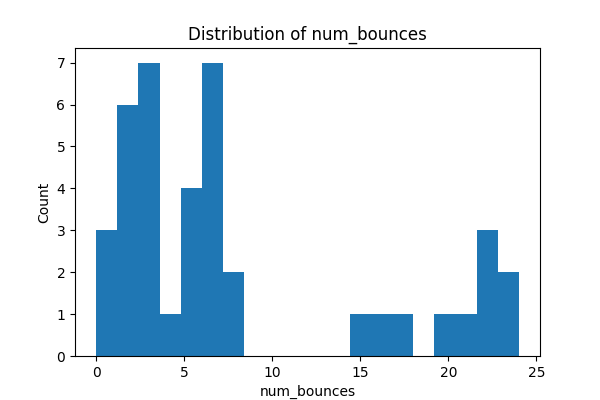

In [5]:
_= vis.create_histogram("num_bounces", interactive=True)

In [6]:
import statistics as sts

# storing the simulation data locally to calculate descriptive statistics
test_num_bounces, gravity, x_pos, y_pos, z_pos, x_vel, y_vel, z_vel = [], [], [], [], [], [], [], []

# accessing and sampling the data for our surrogate model
for group in groups:
    id_pool = list(recs.find_with_data(group_id=group))
    for _, rec_id in enumerate(id_pool):
        rec = recs.get(rec_id)
        data = rec.data_values
        test_num_bounces.append(data["num_bounces"])
        gravity.append(data["gravity"])
        x_pos.append(data["x_pos_initial"])
        y_pos.append(data["y_pos_initial"])
        z_pos.append(data["z_pos_initial"])
        x_vel.append(data["x_vel_initial"])
        y_vel.append(data["y_vel_initial"])
        z_vel.append(data["z_vel_initial"])

# calculating sigma for our output
nb_std = sts.stdev(test_num_bounces)

# calculating sigmas for each input
sig_g = sts.stdev(gravity)
sig_x = sts.stdev(x_pos)
sig_y = sts.stdev(y_pos)
sig_z = sts.stdev(z_pos)
sig_vx = sts.stdev(x_vel)
sig_vy = sts.stdev(y_vel)
sig_vz = sts.stdev(z_vel)

Now that we've generated data, we need to load the inputs and output into our Markov chain Monte Carlo. 

**Note** that for each study in a group, gravity and initial position remain constant. It is the initial velocity of the ball that is changing between each study. 

### Trata

The Trata package allows a user to create samples using various Bayesian sampling methods. Using Sina, we can easily access our "observed" input data and sample those values using the `DefaultValueSampler`. We are assuming we know the gravity acting on the ball and we can count the number of bounces each ball makes. These will be our observables, the former being a feature and the later being our target. 

We also have other features, or parameters, that affect the number of times the ball bounces, which include the position the ball is dropped and the initial velocity of the dropped ball. We will assume those are our unobserved features, or parameters, that introduce uncertainty. We will sample those parameters from the parameter ranges outlined above using `Latin Hypercube Sampling` (LHS) method provided by Trata.

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor

# number of samples from parameter space to be generated
N = 25*len(groups)   

# instantiating the MCMC object
vanilla_exp = mc.DefaultMCMC()

# accessing and sampling the data for our surrogate model
# we need to allocate training data from our previously run simulations to train a machine learning surrogate model
# we will be training our model on gravity and num_bounces from our simulation data as well as position and velocity samples from Trata
for _, (g, b) in enumerate(zip(gravity, test_num_bounces)):
        # setting sample parameter variables
        samples = cs.Samples()
        samples.set_continuous_variable('gravity', 1, g, 10)
        samples.set_continuous_variable('x_pos_initial', 0, 50, 100)
        samples.set_continuous_variable('y_pos_initial', 0, 50, 100)
        samples.set_continuous_variable('z_pos_initial', 0, 50, 100)
        samples.set_continuous_variable('x_vel_initial', -10, 0, 10)
        samples.set_continuous_variable('y_vel_initial', -10, 0, 10)
        samples.set_continuous_variable('z_vel_initial', -10, 0, 10)

        # generating samples
        samples.generate_samples(['x_pos_initial', 'y_pos_initial','z_pos_initial',
                'x_vel_initial','y_vel_initial','z_vel_initial'], sm.LatinHyperCubeSampler(), num_points = N)  
        samples.generate_samples(['gravity'], sm.DefaultValueSampler(), num_points = N) 

        runs = [themis.Run(sample, args='--input_deck input_deck') for sample in samples]      
        mgr = themis.Themis.create_overwrite('../ball_bounce/dist/ball_bounce',
            runs=runs,
            run_dir_names=os.path.join('../ball_bounce/03_simulation_ensembles/themis_ensembles/ensemble/ens_' + str(_), '{run_id}'),
            run_parse='../ball_bounce/input_deck',
            app_is_batch_script=False,
            setup_dir="../ball_bounce/03_simulation_ensembles/themis_ensembles/setup/.ens_" + str(_) + "_setup",
        )
        mgr.execute_local(blocking=True)
        print("run{}: ".format(_+1), mgr.progress())  

        # our target training data
        train_num_bounces = mgr.as_dataframe(include_none=True)[["result"]].to_numpy() 
        
        # our sampled feature training data
        train_features = samples.get_points(['gravity', 'x_pos_initial', 'y_pos_initial','z_pos_initial',
                'x_vel_initial','y_vel_initial','z_vel_initial'], scaled=False)        
        
        # we have opted to use a Guassian Process Regressor as our surrogate model for this problem
        surrogate_model = GaussianProcessRegressor()

        # fitting the surrogate model using our parameter samples and the number of bounces simulated for those parameters
        surrogate_model.fit(train_features, train_num_bounces)        
        
        # adding the target testing data and our fitted model as output to the MCMC for each observed num_bounces
        vanilla_exp.add_output('output', 'num_bounces', surrogate_model, b, nb_std, 
                ['gravity', 'x_pos_initial', 'y_pos_initial','z_pos_initial','x_vel_initial','y_vel_initial','z_vel_initial'])


(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


In [8]:
# adding the input data to our MCMC
vanilla_exp.add_input('gravity', 1, 10, sig_g)
vanilla_exp.add_input('x_pos_initial', 0, 100, sig_x)
vanilla_exp.add_input('y_pos_initial', 0, 100, sig_y)
vanilla_exp.add_input('z_pos_initial', 0, 100, sig_z)
vanilla_exp.add_input('x_vel_initial', -10, 10, sig_vx)
vanilla_exp.add_input('y_vel_initial', -10, 10, sig_vy)
vanilla_exp.add_input('z_vel_initial', -10, 10, sig_vz)


# running MCMC chain 
vanilla_exp.run_chain(total=10000, burn=10000, every=2, n_chains=16, prior_only=True)
print(vanilla_exp.diagnostics_string())

prior_chains = vanilla_exp.get_chains(flattened=True)
prior_points = np.stack(prior_chains.values()).T

BurningBurning

Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Sampling StartSampling Start

Sampling Start
Sampling Start
Sampling StartSampling Start
Sampling Start
Sampling Start

Sampling Start
Sampling Start
Sampling Start
Sampling StartSampling Start

Sampling Start
Sampling Start
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling Start
Sampling: 10%Sampling: 10%

Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 30%
Sampling: 30%Sampling: 30%

Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 20%
Sampling: 30%
Sampling: 30%Sampling: 30%

Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sa

/g/g20/eljurf1/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### Diagnostics

$\hat{R}$ is a diagnostic that determines convergence (whether or not the chain has fully explored the whole distribution.) This value depends on the variance within chains and between chains. If this is too high it means that the chain has not been run long enough to fully converge to the target distribution.

#### Trace and Autocorrelation Plots for Each Input Parameter

Trace plots of samples versus the simulation index can be very useful in assessing convergence. The trace tells you if the chain has not yet converged to its stationary distribution—that is, if it needs a longer burn-in period. A trace can also tell you whether the chain is mixing well. A chain might have reached stationarity if the distribution of points is not changing as the chain progresses. The aspects of stationarity that are most recognizable from a trace plot are a relatively constant mean and variance. A chain that mixes well traverses its posterior space rapidly, and it can jump from one remote region of the posterior to another in relatively few steps.

From what we can observe from the trace plots produced, the results display a "perfect" trace plot. Note that the center of the chain appears to be around the midrange value of the parameter ranges, with very small fluctuations. This indicates that the chain *could* have reached the right distribution. The chain is mixing well; it is exploring the distribution by traversing to areas where its density is very low. You can conclude that the mixing is quite good here. 

In [11]:
def auto_trace(params):
    for param in params:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
        vanilla_exp.trace_plot(param, ax=axes[0])
        vanilla_exp.autocorr_plot(param, ax=axes[1])
        axes[0].title.set_text("{} trace plot".format(param))
        axes[0].set(xlabel="iteration", ylabel="{} value".format(param))
        axes[1].title.set_text("{} autocorrelation plot".format(param))
        axes[1].set(xlabel="lag", ylabel="ACF")
        fig.tight_layout()
        fig.savefig("../ball_bounce/06_surrogate_model/uq_plots/{}_trace_and_autocorrelation_plots.png".format(param))
        plt.close(fig)

In [12]:

auto_trace(['gravity','x_pos_initial','y_pos_initial','z_pos_initial','x_vel_initial','y_vel_initial','z_vel_initial'])


Before only the prior was considered, now the likelihood is calculated. We need to calculate the likelihood in order to generate likelihood plots discussed below. 

In [13]:

vanilla_exp.run_chain(total=10000, burn=10000, every=30, n_chains=16, prior_only=False)
print(vanilla_exp.diagnostics_string())

post_chains = vanilla_exp.get_chains(flattened=True)
post_points = np.stack(post_chains.values()).T

Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning

BurningBurning
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling StartSampling Start

Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%Sampling: 20%

Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sa

/g/g20/eljurf1/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/g/g20/eljurf1/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


acceptance_rate:0.0
gravity:
  r_hat:3593592932347945.0
  n_eff:16.00480144043213
  var_hat:8.796246078834836
  mean:5.353815027006218
  std:2.919137439188372
  mode:2.2866445708663012
x_pos_initial:
  r_hat:3271405840238701.5
  n_eff:16.00480144043213
  var_hat:1082.9627638983395
  mean:50.92789954220107
  std:32.39012469143206
  mode:1.070791293414245
y_pos_initial:
  r_hat:2854044487798323.0
  n_eff:16.00480144043213
  var_hat:823.4602816777075
  mean:55.75025235332995
  std:28.244063940504017
  mode:4.491146972828976
z_pos_initial:
  r_hat:2588174484268009.5
  n_eff:16.00480144043213
  var_hat:903.7962068477528
  mean:56.25074631629093
  std:29.589737670073394
  mode:9.72143882521052
x_vel_initial:
  r_hat:5159418748477092.0
  n_eff:16.00480144043213
  var_hat:22.972429224944495
  mean:-0.10947555004643073
  std:4.71747186654727
  mode:-9.666615101557902
y_vel_initial:
  r_hat:3511471055744307.5
  n_eff:16.00480144043213
  var_hat:32.38877498113307
  mean:1.1693393453042171
  std:5

### Likelihood Plots

The likelihood is the probability that a particular outcome $x$ is observed when the true value of the parameter is $\theta$, equivalent to the probability mass on $x$; it is *not* a probability density over the parameter $\theta$.

The probability plot is a graphical technique for assessing whether or not a data set follows a given distribution such as the normal distribution.

The data are plotted against a theoretical distribution in such a way that the points should form approximately a straight line. Departures from this straight line indicate departures from the specified distribution. 

In [15]:
for key in post_chains.keys():
    fig, ax = plt.subplots(1, 1)
    ax.title.set_text(key)
    plots.likelihood_plot(ax, prior_chains[key], post_points=post_chains[key])
    fig.savefig("../ball_bounce/06_surrogate_model/uq_plots/{}_likelihood_plot.png".format(key))
    plt.close(fig)


### Appendix

#### Metropolis algorithm 

Provides a mechanism to explore the entire configuration space by random walk. At each step, the algorithm performs a random modification to the current state to obtain a new state. The new state is either accepted or rejected with a probability computed based on energy change in the transition. The states generated by the algorithm form a Markov chain.

|Metropolis Algorithm|
|--------------------|
|1: Randomize an input $g$.|
|2: **repeat** |
|3: &nbsp; Generate $g^*$ by performing a random trial move from $g$.|
|4: &nbsp; Compute $Pr(g \rightarrow g^*)=$ min $\left\{1,\frac{Pr(g^*)}{Pr(g)}\right\}$|
|5: &nbsp; if _random_ $(0,1]<Pr(g \rightarrow g^*)$ then $g \rightarrow g^*$.|
|6: **until** equilibrium is attained.|


#### Gibbs sampler 
A special case of the Metropolis algorithm, which generates new states by using univariate conditional probabilities. Because direct sampling from the complex joint distribution of all random variables is difficult, Gibbs sampler instead simulate random variables one by one from the univariate conditional distribution. A univariate conditional distribution involves only one random variable conditioned on the rest variables having fixed values, which is usually in a simple mathematical form.

|Gibbs Sampling Algorithm|
|------------------------|
|1: Randomize an input $g$.|
|2: **repeat** |
|3: &nbsp; **for all** $i \in R$ **do**|
|4: &nbsp;&nbsp;&nbsp;&nbsp; Compute $Pr(g_i = q \| g^i)$ for all $q \in Q$.|
|5: &nbsp;&nbsp;&nbsp;&nbsp; Assign $g_i$ to the value $q$ with the probability $Pr(g_i = q \| g^i)$.|
|6: &nbsp; **end for** |
|7: **until** equilibrium is attained.|